In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.utils import shuffle

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('datasets/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf

2023-03-02 11:24:25.516154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data = pd.read_json("datasets/dataset.json")
data.drop(['violation'], axis=1, inplace=True)


data = shuffle(data)

df = data[:1000]

test =  data[1001:1501]# pd.read_json("datasets/test_data.json")

In [4]:
df.head()

,text,hasBadWords
36474,"CUMSHOTS, BEHIND THE SCENES - BTS ATasteOf...",False
23722,College is Expensive: Dorm Room Audition,False
84238,<center><div class='top_html' align='center'><...,False
54909,Lady Luci sucks cock and fucks it too!,False
37854,"FUCKING, BOY-GIRL, TEEN 18 OR 19, TEACHER FETI...",False


In [5]:
df["hasBadWords"].value_counts()

False    947
True      53
Name: hasBadWords, dtype: int64

<AxesSubplot: xlabel='count', ylabel='hasBadWords'>

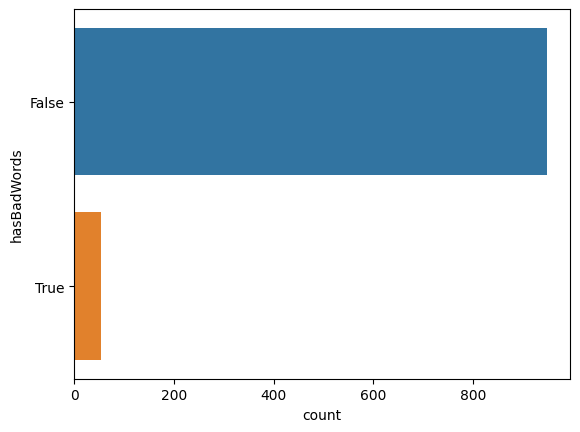

In [6]:
sns.countplot(y = df['hasBadWords'])

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.stem import WordNetLemmatizer
import contractions

In [8]:
stop_word = set(stopwords.words("english"))

In [9]:
punt = punctuation.replace("!","").replace("?","")

In [10]:
def text_tokenize(text):
    tokenizer = word_tokenize(text, language='english', preserve_line=False)
    lemmatizer = WordNetLemmatizer()
    tokens = tokenizer #.tokenize(contractions.fix(text))
    
    pruned = []
    
    for token in tokens:
        if token not in punctuation and not token.startswith("http"):
            if token.startswith("@"):
                token = token.replace("@","")
                pruned.append(lemmatizer.lemmatize(token.lower()))

            else:
                
                pruned.append(lemmatizer.lemmatize(token.lower()))
            
    return pruned
clean_text = df["text"].apply(lambda x: text_tokenize(x))
clean_text.head()

36474    [cumshots, behind, the, scene, bts, atasteofta...
23722       [college, is, expensive, dorm, room, audition]
84238    [center, div, class='top_html, align='center, ...
54909         [lady, luci, suck, cock, and, fuck, it, too]
37854    [fucking, boy-girl, teen, 18, or, 19, teacher,...
Name: text, dtype: object

In [11]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(clean_text, df["hasBadWords"], test_size=0.3, random_state=2023, stratify=df["hasBadWords"])
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((700,), (300,), (700,), (300,))

In [12]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer

In [13]:
# Reshape column 
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

In [14]:
one_hot_encode = OneHotEncoder(sparse_output=False)

In [15]:
y_train = one_hot_encode.fit_transform(y_train)
y_test = one_hot_encode.transform(y_test)

In [16]:
X_train = X_train.to_list()
X_test = X_test.to_list()

tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_input_length = np.max([len(x) for x in X_train])

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding= "post", maxlen = max_input_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding= "post", maxlen = max_input_length)


# Import LSTM**

In [17]:
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

In [18]:
max_vocab = len(tokenizer.word_index) + 1
input_data = Input((max_input_length,), name= "input_layer")
embedding_output = Embedding(max_vocab, 100, mask_zero = True, name = "embedding_layer")(input_data)

2023-03-02 11:24:36.817312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
dropout = SpatialDropout1D(0.5, name = "dropout_layer")(embedding_output)
lstm_output = Bidirectional(LSTM(100, dropout = 0.5, recurrent_dropout = 0.2, return_state = False, 
                                name = "lstm_layer"))(dropout)
output_data = Dense(2, activation = "softmax")(lstm_output)

In [20]:
lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=50, decay_rate=0.9, staircase=False)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.weight_decay(tf.float32)
    return lr

optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

lr_metric = get_lr_metric(optimizer)

model = tf.keras.Model(input_data, output_data)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3642)]            0         
                                                                 
 embedding_layer (Embedding)  (None, 3642, 100)        584300    
                                                                 
 dropout_layer (SpatialDropo  (None, 3642, 100)        0         
 ut1D)                                                           
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 745,502
Trainable params: 745,502
Non-trainable

In [21]:
model.fit(X_train, y_train, batch_size = 512, epochs = 4, validation_data = (X_test, y_test))

Epoch 1/4
2/2 [==============================] - 298s 98s/step - loss: 0.6600 - accuracy: 0.6257 - val_loss: 0.5123 - val_accuracy: 0.9467
Epoch 2/4
2/2 [==============================] - 2729s 384s/step - loss: 0.4066 - accuracy: 0.9471 - val_loss: 0.2925 - val_accuracy: 0.9467
Epoch 3/4
2/2 [==============================] - 2155s 95s/step - loss: 0.2382 - accuracy: 0.9471 - val_loss: 0.2570 - val_accuracy: 0.9467
Epoch 4/4
2/2 [==============================] - 356s 103s/step - loss: 0.1717 - accuracy: 0.9529 - val_loss: 0.2279 - val_accuracy: 0.9433


In [22]:
model.save('models/lstm.model')

INFO:tensorflow:Assets written to: models/lstm.model/assets


INFO:tensorflow:Assets written to: models/lstm.model/assets


In [23]:
test.head()

,text,hasBadWords
29177,<p>Sit back and enjoy multiple clips of Laina....,False
81176,Sofi Gyllen,False
53165,9869 Clip Store,False
83585,bbw chubby feedee feeder mutual gainer feederi...,False
59396,"fetish, facials, pov's, blowjobs, handjobs,han...",False


In [24]:
# normalize and toknize to test data
text = test["text"]
text = text.apply(lambda x : text_tokenize(x))
text = text.to_list()
text = tokenizer.texts_to_sequences(text)
text = tf.keras.preprocessing.sequence.pad_sequences(text, padding = "post", maxlen = max_input_length)

In [25]:
text

array([[   6, 1021,  271, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [  24,   42,    0, ...,    0,    0,    0],
       ...,
       [1222,   44,  602, ...,    0,    0,    0],
       [  24,   42,    0, ...,    0,    0,    0],
       [ 824, 1629,   21, ...,    0,    0,    0]], dtype=int32)

In [26]:
# predictions 
pred = model.predict(text)
hasBadWords = one_hot_encode.inverse_transform(pred)
test["Prediction"] = hasBadWords

16/16 [==============================] - 48s 3s/step


/var/folders/mm/2c6bnjk559g2btv241j7f9lh0000gn/T/ipykernel_5326/2468171593.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Prediction"] = hasBadWords


In [27]:
test.head()

,text,hasBadWords,Prediction
29177,<p>Sit back and enjoy multiple clips of Laina....,False,False
81176,Sofi Gyllen,False,False
53165,9869 Clip Store,False,False
83585,bbw chubby feedee feeder mutual gainer feederi...,False,False
59396,"fetish, facials, pov's, blowjobs, handjobs,han...",False,False


In [28]:
accuracy = np.sum(test["hasBadWords"] == test["Prediction"]) / len(test)
print("accuracy = {}".format(accuracy))

accuracy = 0.972


In [29]:
# Wrong prediction 
test[test["hasBadWords"] != test["Prediction"]]

,text,hasBadWords,Prediction
70379,"<br>\r\n<br>\r\n<P ALIGN=""CENTER"">\r\n<A HREF=...",True,False
53905,A den of tickle torture sex,True,False
62407,"Foot fetish, footjobs, female domination, Tram...",True,False
67471,"<table width=""795"" border=""0"">\r\n <tr> \r\...",False,True
5608,<p>Detective Hollywood is once again in search...,True,False
64506,"<p><CENTER><img src=""http://imagecdn.clips4sal...",True,False
65846,<center><div class='top_html' align='center'><...,True,False
63843,<center><div class='top_html' align='center'><...,True,False
28458,<p>Lory enjoys a strong horse. She rides on yo...,True,False
66675,all videos are explicit and all are hard core ...,True,False
